In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal
from rmab.plots import plot_line_plot_parameter, plot_tradeoff_curve, process_two_parameter_data, process_one_parameter_data, process_zero_parameter_data, aggregate_data
import seaborn as sns
import itertools 

In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

## NeurIPS 2024 Plots

### Baseline Plots

Text(93.72222222222221, 0.5, 'Total Reward')

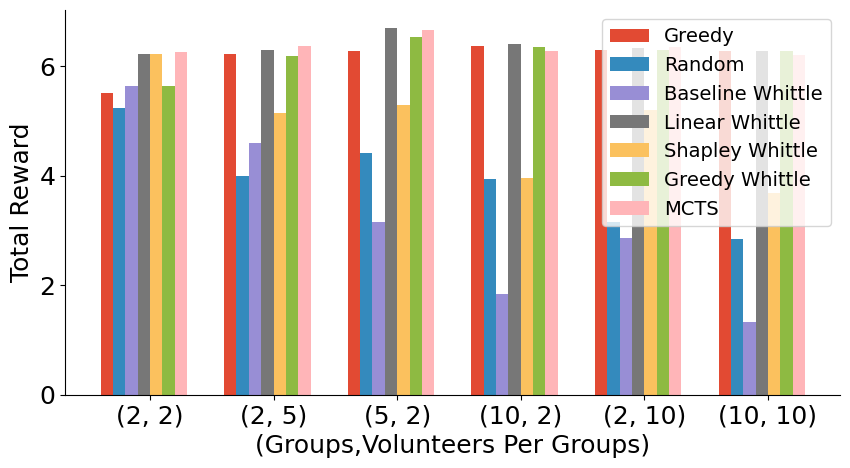

In [5]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_volunteers.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

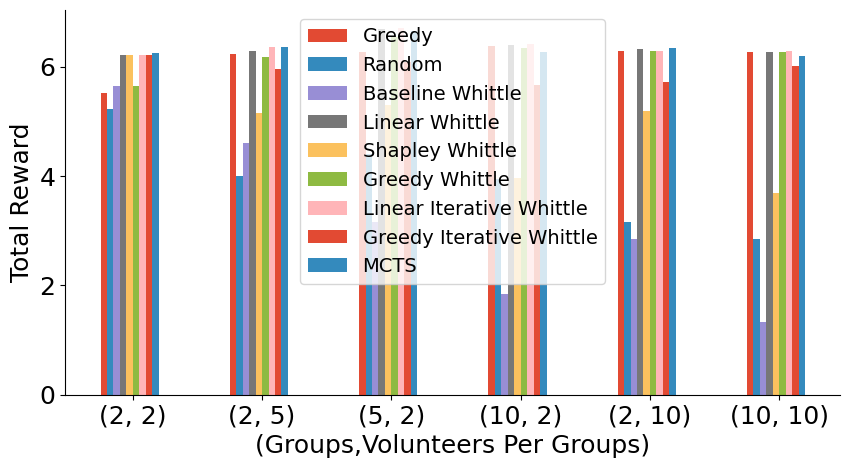

In [6]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','iterative_whittle','iterative_greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","Linear Iterative Whittle","Greedy Iterative Whittle","MCTS"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.05
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_iterative_volunteers.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(69.84722222222221, 0.5, 'Total Reward')

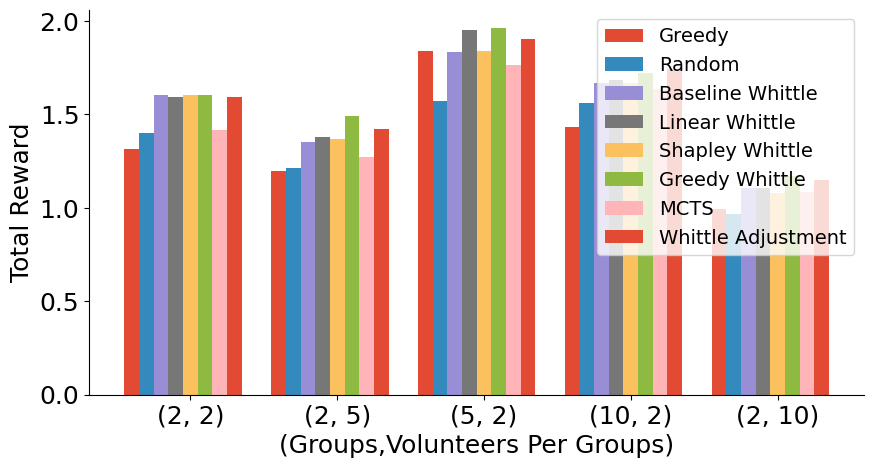

In [7]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts','linear_whittle_adjsuted']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS","Whittle Adjustment"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "real_data_mcts"
    else:
        dataset = "real_data"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/real_data_volunteers.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

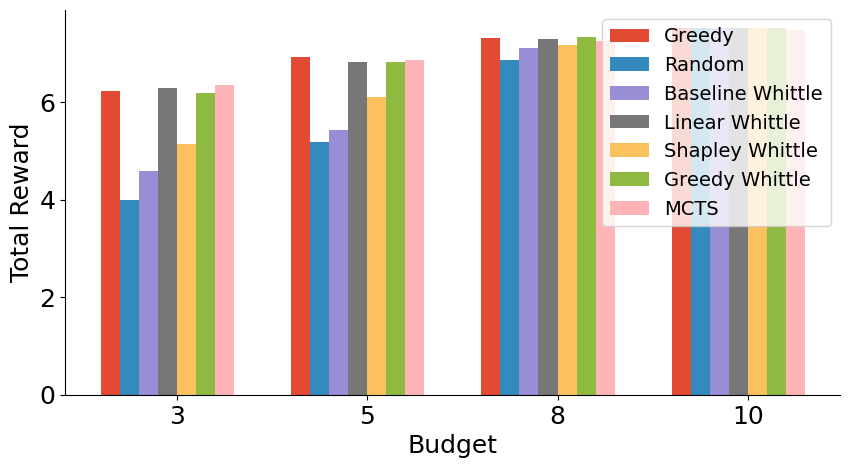

In [8]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
budgets = [3,5,8,10]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

Text(69.84722222222221, 0.5, 'Total Reward')

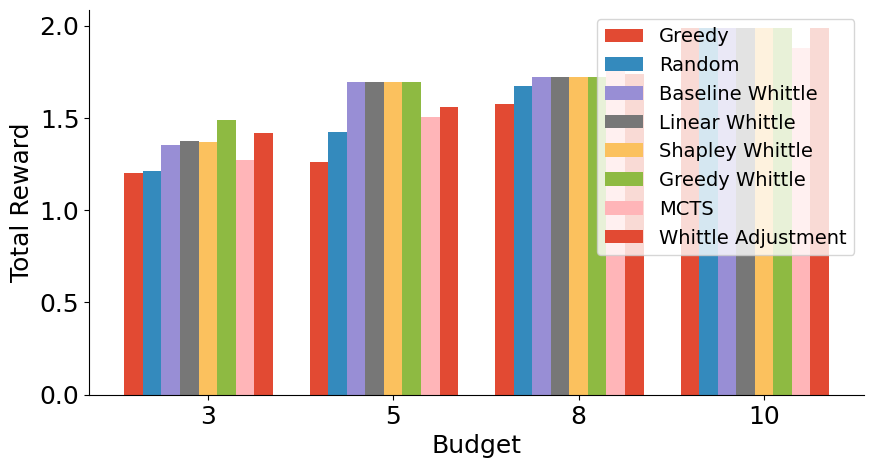

In [9]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts','linear_whittle_adjsuted']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS","Whittle Adjustment"]
budgets = [3,5,8,10]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "real_data_mcts"
    else:
        dataset = "real_data"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/real_data_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

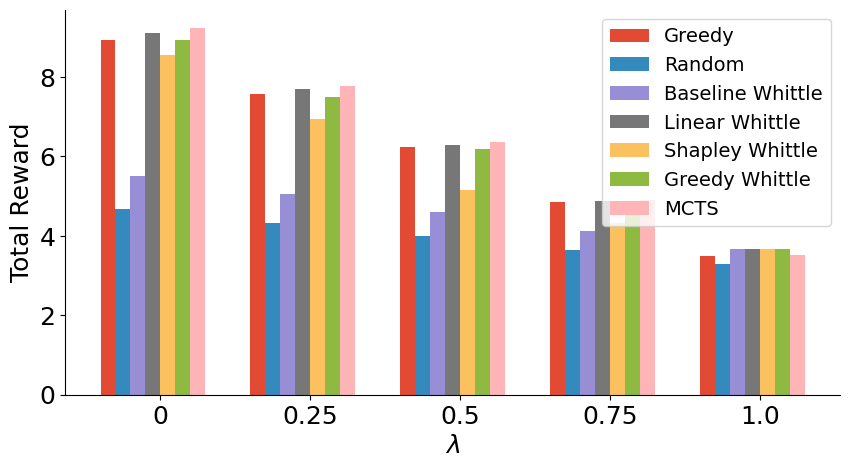

In [10]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_lambda.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")

Text(69.84722222222221, 0.5, 'Total Reward')

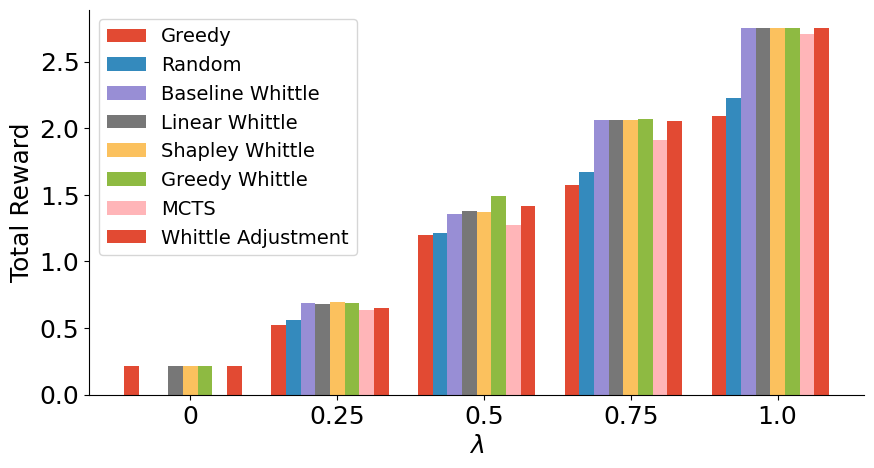

In [11]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts','linear_whittle_adjsuted']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS","Whittle Adjustment"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "real_data_mcts"
    else:
        dataset = "real_data"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/real_data_lambda.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

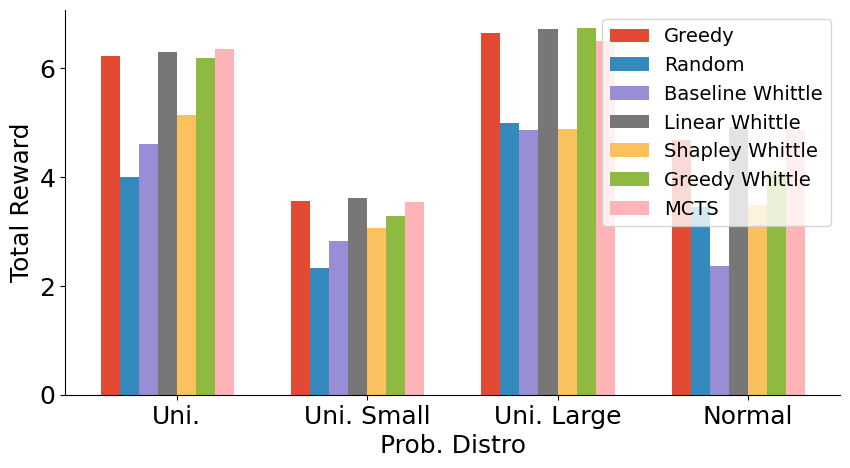

In [12]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
distros = ['uniform','uniform_small','uniform_large','normal']
distro_nice = ['Uni.','Uni. Small','Uni. Large','Normal']
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for d in distros:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': 3, 'prob_distro': d, 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(distros))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_distros.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(distros))))+width*len(method_names)/2,distro_nice)
plt.xlabel("Prob. Distro")
plt.ylabel("Total Reward")

### Policy Function Only

Text(48.722222222222214, 0.5, 'Total Reward')

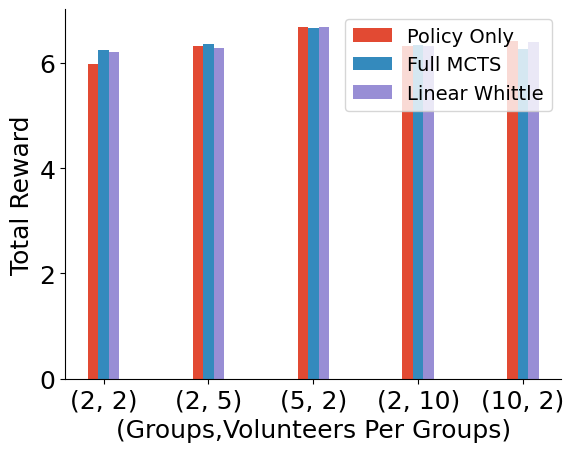

In [13]:
arm_volunteer_combos = [(2,2),(2,5),(5,2),(2,10),(10,2)]

policies = ["mcts","mcts","linear_whittle"]
dataset_names = ["mcts_exploration/value_policy_exploration/policy_only","semi_synthetic_mcts","semi_synthetic"]
policy_names = ["Policy Only","Full MCTS","Linear Whittle"]
width = 0.1

for i,(dataset,name) in enumerate(zip(dataset_names,policy_names)):
    score_by_n = []

    for arms, volunteers in arm_volunteer_combos:
        results_policy = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results_policy = aggregate_data(results_policy)

        score_by_n.append(results_policy['{}_reward'.format(policies[i])][0])
    plt.bar(np.array(list(range(len(arm_volunteer_combos))))+i*width,score_by_n,width=width,label=policy_names[i])
plt.legend()
plt.savefig("../../results/figures/policy_only.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arm_volunteer_combos))))+width*(len(dataset_names)-1)/2,arm_volunteer_combos)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")


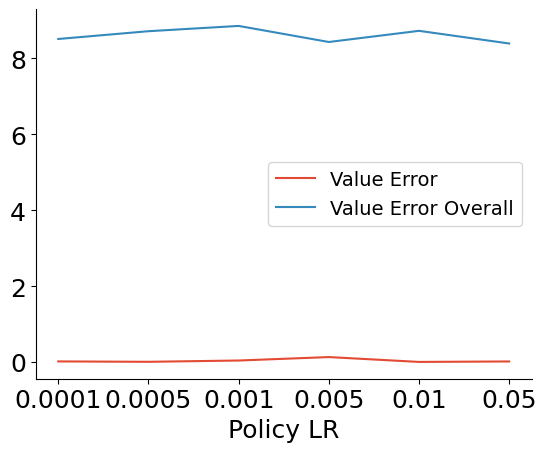

In [14]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
policy_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for policy_lr in policy_lrs:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': policy_lr, 'value_lr': 0.01, 'n_episodes': 200, 'train_iterations': 30})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.plot(list(range(len(policy_lrs))),value_error_rate,label="Value Error")
plt.plot(list(range(len(policy_lrs))),value_error_overall_rate,label="Value Error Overall")
plt.xticks(list(range(len(policy_lrs))),policy_lrs)
plt.xlabel("Policy LR")
plt.legend()


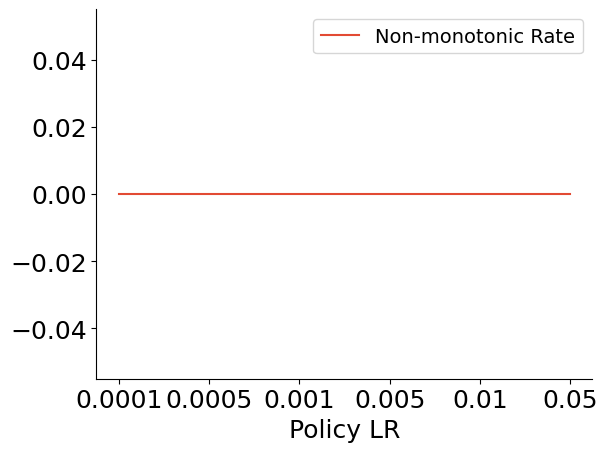

In [15]:
# Comparison with baselines
# Impact of Learning Rate
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
policy_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for policy_lr in policy_lrs:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': policy_lr, 'value_lr': 0.01, 'n_episodes': 200, 'train_iterations': 30})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.xticks(list(range(len(policy_lrs))),policy_lrs)
plt.plot(list(range(len(policy_lrs))),monotonicity_rate,label="Non-monotonic Rate")
plt.xlabel("Policy LR")
plt.legend()

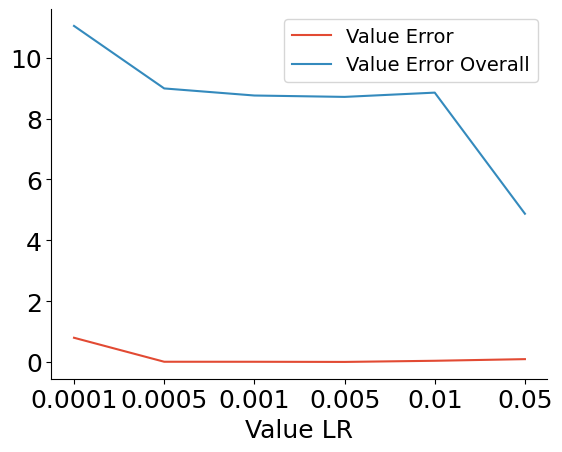

In [16]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
value_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for value_lr in value_lrs:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 1e-3, 'value_lr':value_lr, 'n_episodes': 200, 'train_iterations': 30})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.plot(list(range(len(policy_lrs))),value_error_rate,label="Value Error")
plt.plot(list(range(len(policy_lrs))),value_error_overall_rate,label="Value Error Overall")
plt.xticks(list(range(len(policy_lrs))),policy_lrs)
plt.xlabel("Value LR")
plt.legend()


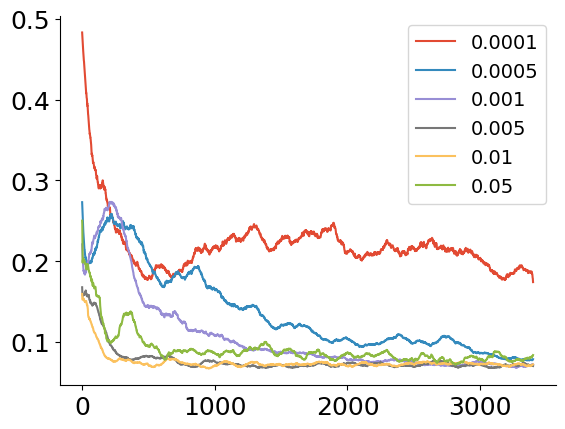

In [17]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]


monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
value_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for i,value_lr in enumerate(value_lrs):
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':value_lr, 'n_episodes': 200, 'train_iterations': 30})
    all_value_losses = [i['value_loss'] for i in results]
    all_value_losses = np.mean(np.array(all_value_losses),axis=0)
    plt.plot(plot_sliding_window(all_value_losses),label=value_lr)
plt.legend()

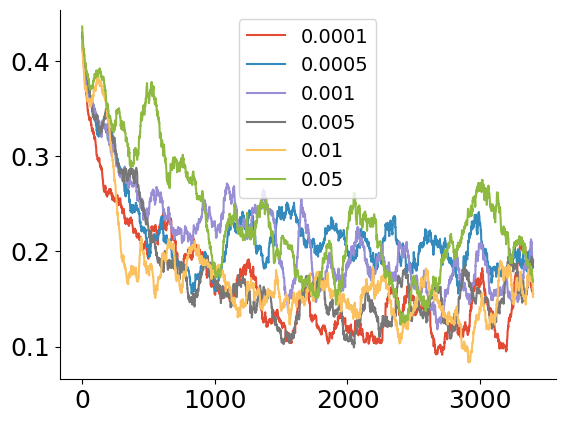

In [18]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]


monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
value_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for i,value_lr in enumerate(value_lrs):
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':value_lr, 'n_episodes': 200, 'train_iterations': 30})
    all_value_losses = [i['policy_loss'] for i in results]
    all_value_losses = np.mean(np.array(all_value_losses),axis=0)
    plt.plot(plot_sliding_window(all_value_losses),label=value_lr)
plt.legend()

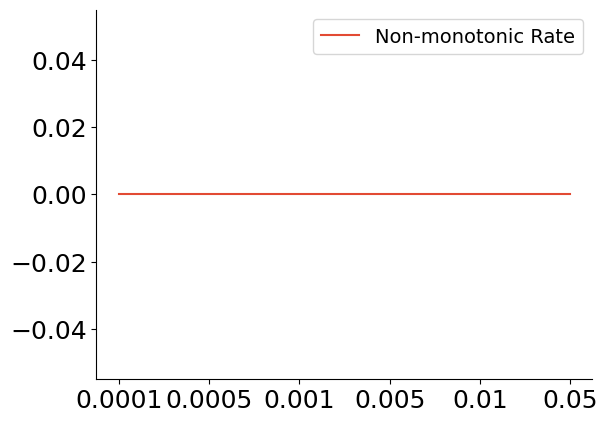

In [19]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
value_lrs = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
for value_lr in value_lrs:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':value_lr, 'n_episodes': 200, 'train_iterations': 30})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
plt.plot(list(range(len(value_lrs))),monotonicity_rate,label="Non-monotonic Rate")
plt.xticks(list(range(len(policy_lrs))),policy_lrs)
plt.legend()


In [ ]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
train_iterations = [10,20,30,40,50,60]
for train_iter in train_iterations:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': 200, 'train_iterations': train_iter})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.plot(list(range(len(train_iterations))),value_error_rate,label="Value Error")
plt.plot(list(range(len(train_iterations))),value_error_overall_rate,label="Value Error Overall")
plt.xticks(list(range(len(train_iterations))),train_iterations)
plt.legend()


In [ ]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
train_iterations = [10,20,30,40,50,60]
for train_iter in train_iterations:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': 200, 'train_iterations': train_iter})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.plot(list(range(len(train_iterations))),monotonicity_rate,label="Non-monotonic Rate")
plt.xticks(list(range(len(train_iterations))),train_iterations)
plt.legend()


In [ ]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]


monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
train_iterations = [10,20,30,40,50,60][::-1]
for train_iter in train_iterations:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': 200, 'train_iterations': train_iter})
    all_value_losses = [i['value_loss'] for i in results]
    all_value_losses = np.mean(np.array(all_value_losses),axis=0)
    plt.plot(plot_sliding_window(all_value_losses),label=train_iter)
plt.legend(title="Search Iterations")
plt.ylabel("Policy Loss")
plt.xlabel("Epoch")
plt.savefig("../../results/figures/value_loss.pdf",dpi=300, bbox_inches='tight')


In [ ]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]


monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
train_iterations = [10,20,30,40,50,60]
for train_iter in train_iterations:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': 200, 'train_iterations': train_iter})
    all_value_losses = [i['policy_loss'] for i in results]
    all_value_losses = np.mean(np.array(all_value_losses),axis=0)
    plt.plot(plot_sliding_window(all_value_losses),label=train_iter)
plt.ylabel("Policy Loss")
plt.xlabel("Epoch")
plt.legend(title="Search Iterations")
plt.savefig("../../results/figures/policy_loss.pdf",dpi=300, bbox_inches='tight')


In [ ]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]


monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
episodes = [50,100,200,400]
for episode in episodes:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': episode, 'train_iterations': 30})
    all_value_losses = [i['value_loss'] for i in results]
    all_value_losses = np.mean(np.array(all_value_losses),axis=0)
    print(len(all_value_losses))
    plt.plot(plot_sliding_window(all_value_losses),label=episode)
plt.legend(title="Episodes")
plt.ylabel("Value Loss")
plt.xlabel("Epoch")
plt.savefig("../../results/figures/value_loss_episodes.pdf",dpi=300, bbox_inches='tight')


In [ ]:
monotonicity_rate = []
value_error_rate = []
value_error_overall_rate = []
num_episodes = [50,100,200,400]
for n in num_episodes:
    results = get_results_matching_parameters("mcts_exploration/value_policy_exploration/exploration","",{'volunteers_per_arm': 2, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2, 'policy_lr': 0.001, 'value_lr':0.01, 'n_episodes': n, 'train_iterations': 30})
    results = aggregate_data(results)
    monotonicity_rate.append(results['num_not_monotonic'][0])
    value_error_rate.append(results['value_error_max_action'][0])
    value_error_overall_rate.append(results['value_error_overall'][0])
plt.plot(list(range(len(num_episodes))),value_error_rate,label="Value Error")
plt.plot(list(range(len(num_episodes))),value_error_overall_rate,label="Value Error Overall")
plt.xticks(list(range(len(num_episodes))),num_episodes)
plt.legend()


## Other Submodular Functions

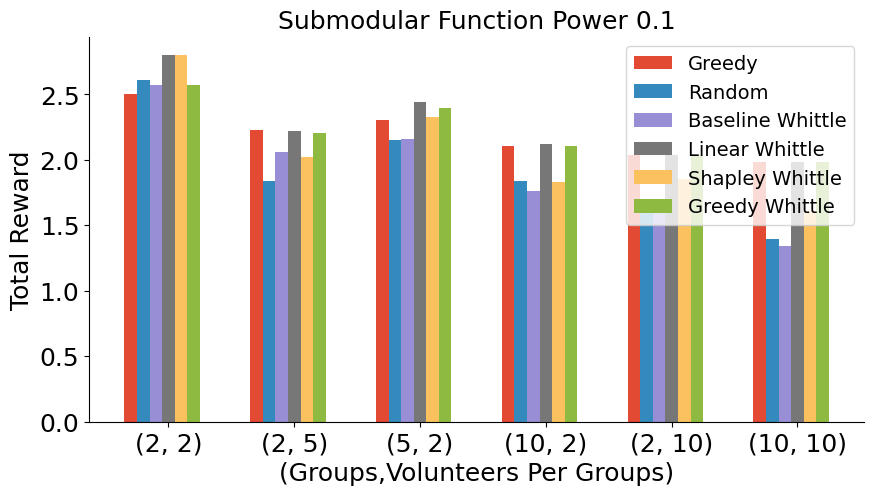

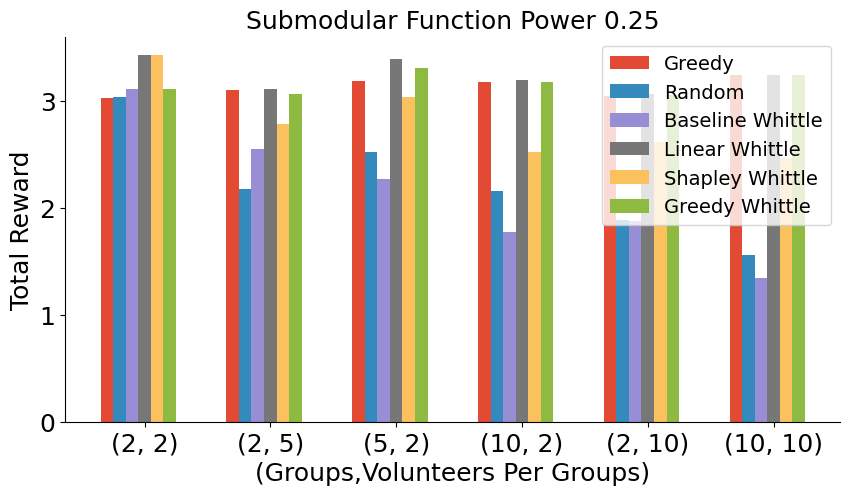

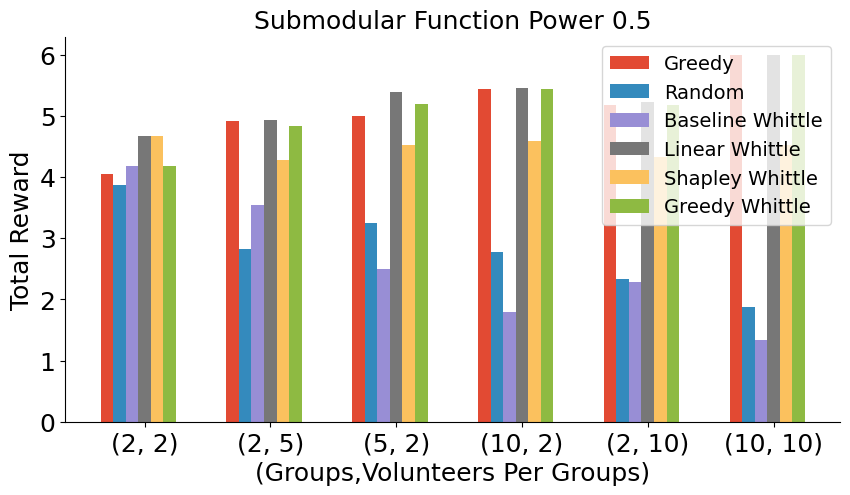

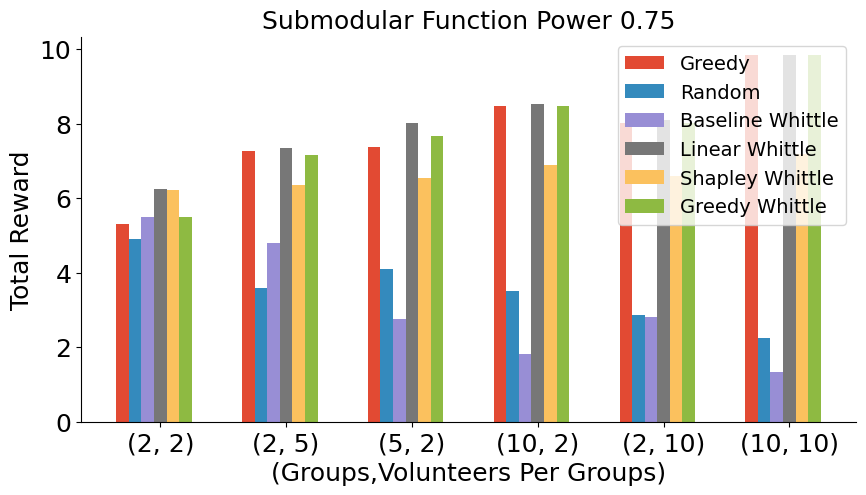

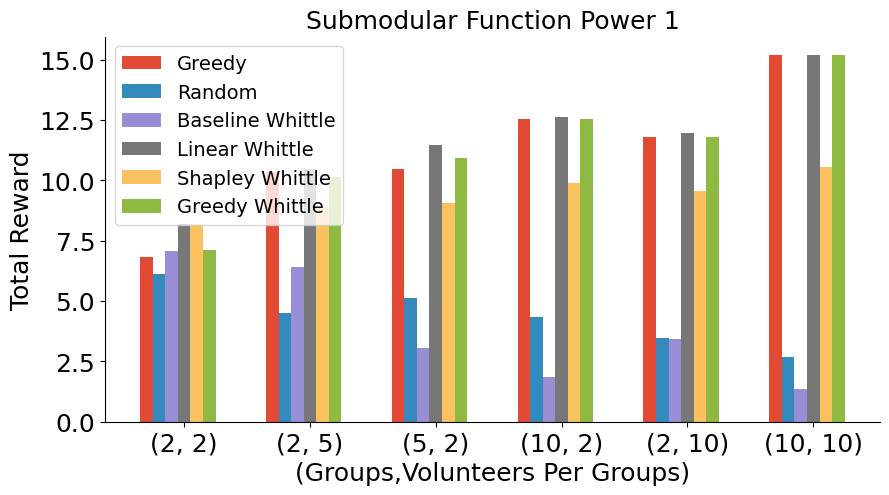

In [21]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.1

for power in [0.1,0.25,0.5,0.75,1]:
    plt.figure(figsize=(10,5))
    plt.title("Submodular Function Power {}".format(power),fontsize=18)
    for i,m in enumerate(method_names):
        score_by_n = []

        dataset = "reward_variation"

        for arms,volunteers in arms_volunteers:
            results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms, 'power': power})
            results = aggregate_data(results)
            
            score_by_n.append(results['{}_reward'.format(m)][0])
        plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
    plt.legend()
    plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
    plt.xlabel("(Groups,Volunteers Per Groups)")
    plt.ylabel("Total Reward")
    plt.savefig("../../results/figures/submodular_{}.pdf".format(power),dpi=300, bbox_inches='tight')


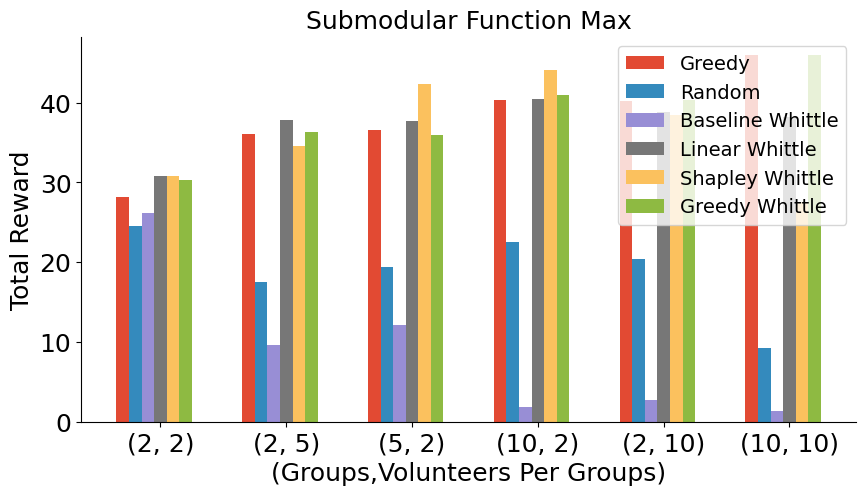

In [ ]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.1

plt.figure(figsize=(10,5))
plt.title("Submodular Function Max",fontsize=18)
for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "reward_variation/max_reward"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'n_arms': arms,})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")
plt.savefig("../../results/figures/max_function.pdf",dpi=300, bbox_inches='tight')


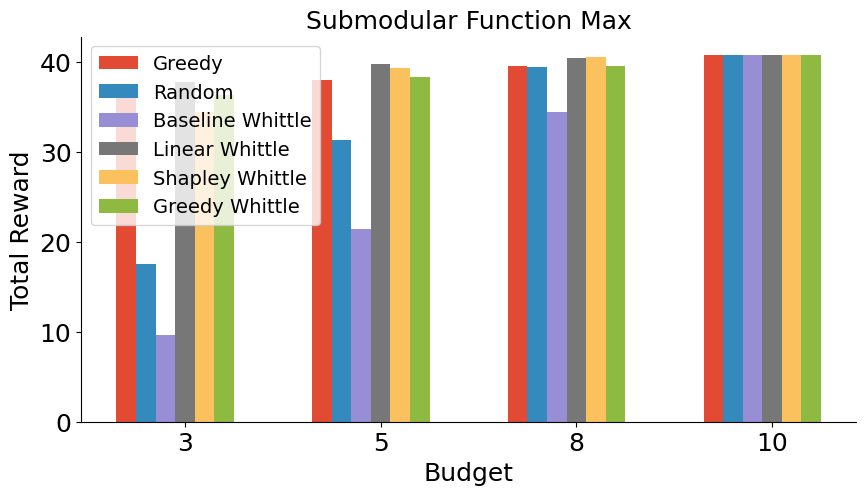

In [ ]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
budgets = [3,5,8,10]
width = 0.1

plt.figure(figsize=(10,5))
plt.title("Submodular Function Max",fontsize=18)
for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "reward_variation/max_reward"

    for budget in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': budget, 'n_arms': 2,})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")
plt.savefig("../../results/figures/max_function_budget.pdf",dpi=300, bbox_inches='tight')


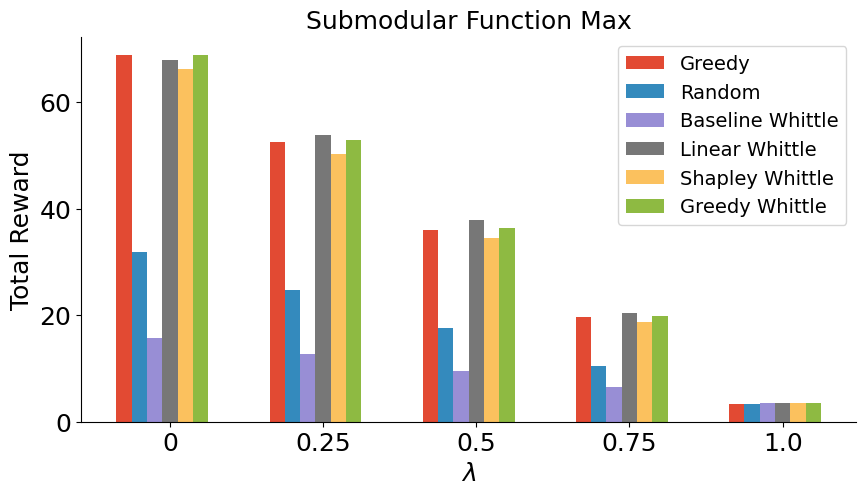

In [ ]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1

plt.figure(figsize=(10,5))
plt.title("Submodular Function Max",fontsize=18)
for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "reward_variation/max_reward"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'n_arms': 2,})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")
plt.savefig("../../results/figures/max_function_lamb.pdf",dpi=300, bbox_inches='tight')


## Bucketing Analysis MCTS

In [ ]:
method_names = ['mcts','mcts_rand_group']
nice_names = ["No Groups","Whittle Group"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_bucketing"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_bucketing.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

In [ ]:
method_names = ['mcts','mcts_rand_group']
nice_names = ["Baseline","Whittle Group"]
budgets = [3,5,8,10]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_bucketing"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_bucketing_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budgets")
plt.ylabel("Total Reward")

In [ ]:
method_names = ['mcts','mcts_rand_group']
nice_names = ["Baseline","Whittle Group"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_bucketing"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_train_time'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_bucketing.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Train Time (s)")

In [ ]:
method_names = ['mcts','mcts_rand_group']
nice_names = ["Baseline","Whittle Group"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_bucketing"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_time'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_bucketing.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Evaluation Time (s)")

## Pure MCTS Runs

Text(69.84722222222221, 0.5, 'Total Reward')

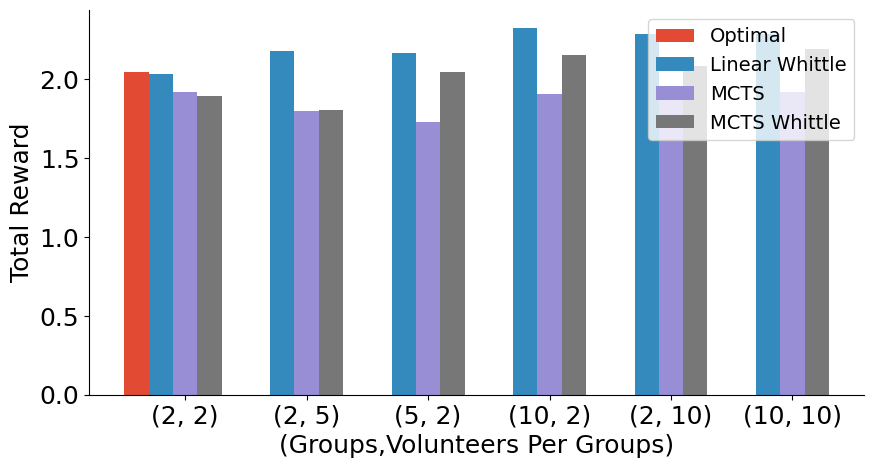

In [5]:
method_names = ['optimal','linear_whittle','mcts','mcts_whittle']
nice_names = ["Optimal","Linear Whittle","MCTS","MCTS Whittle"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_exploration"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_mcts.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

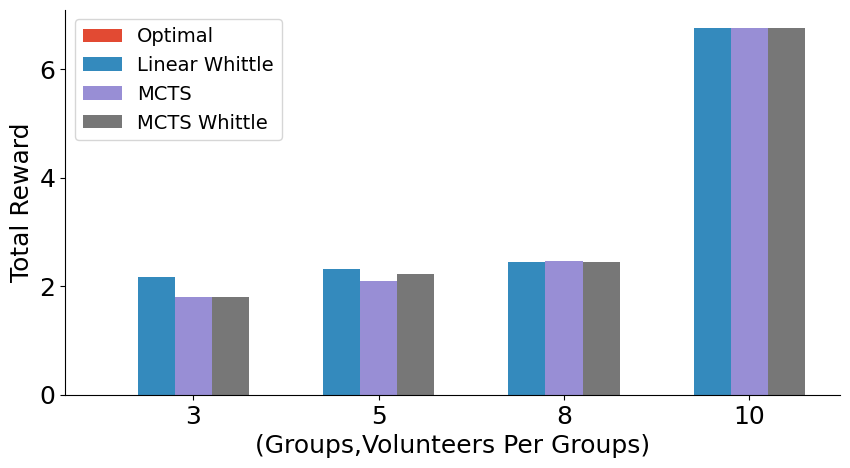

In [6]:
method_names = ['optimal','linear_whittle','mcts','mcts_whittle']
nice_names = ["Optimal","Linear Whittle","MCTS","MCTS Whittle"]
budgets = [3,5,8,10]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_exploration"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

## Pure RL Runs

Text(93.72222222222221, 0.5, 'Total Reward')

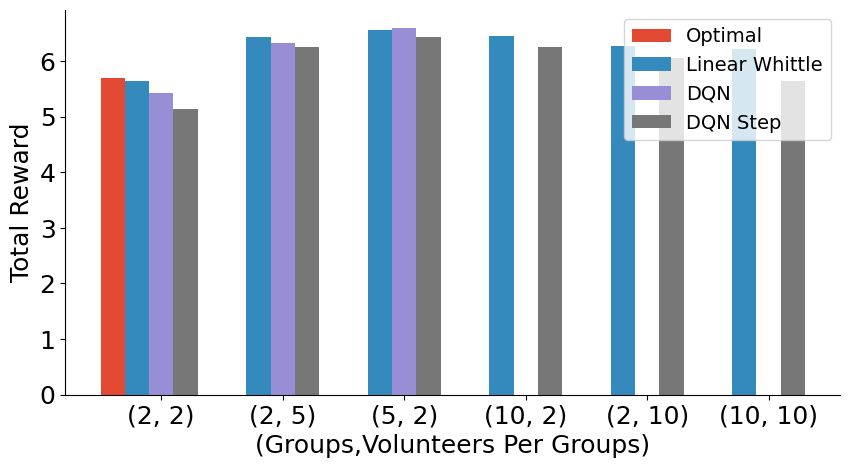

In [18]:
method_names = ['optimal','linear_whittle','dqn','dqn_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Step"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_rl.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

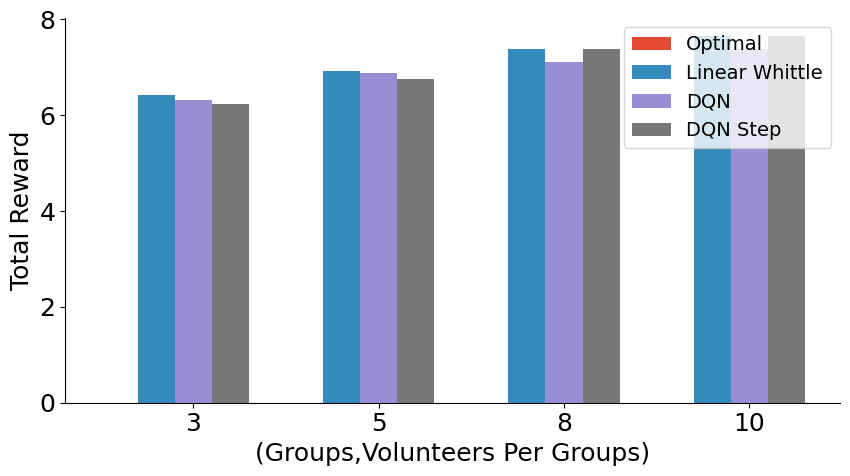

In [19]:
method_names = ['optimal','linear_whittle','dqn','dqn_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Step"]
budgets = [3,5,8,10]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_rl_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

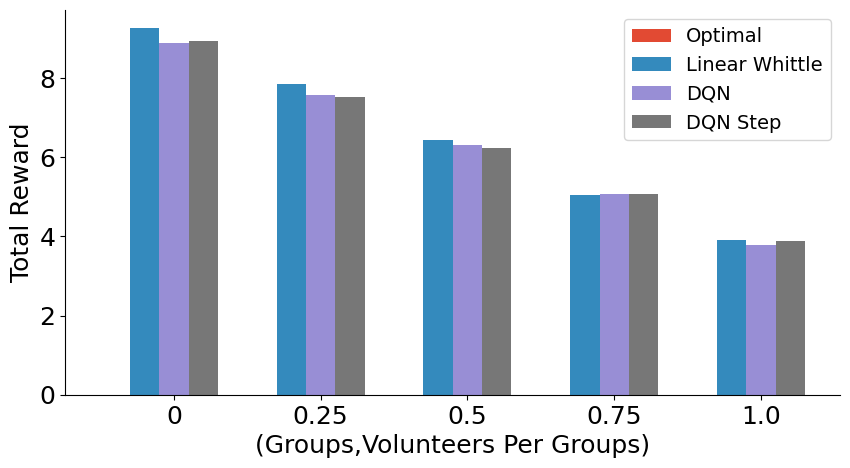

In [20]:
method_names = ['optimal','linear_whittle','dqn','dqn_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Step"]
lamb = [0,0.25,0.5,0.75,1]
width = 0.2
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_rl_lamb.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

## MCTS Ablation

In [ ]:
method_names = ['mcts','mcts_no_group','mcts_rand_group','mcts_whittle_group','mcts_no_train','mcts_no_whittle','mcts_no_ucb','mcts_no_test']
nice_names = ["Baseline","No Bucketing","MCTS Random Group","MCTS Whittle Group","MCTS No Training","MCTS No Whittle","MCTS No UCB","MCTS No Test"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.05
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_ablation"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_ablation.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

In [ ]:
method_names = ['mcts','mcts_no_group','mcts_rand_group','mcts_whittle_group','mcts_no_train','mcts_no_whittle','mcts_no_ucb','mcts_no_test']
nice_names = ["Baseline","No Bucketing","MCTS Random Group","MCTS Whittle Group","MCTS No Training","MCTS No Whittle","MCTS No UCB","MCTS No Test"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.05
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_ablation"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_train_time'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_ablation_time.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Train Time")

In [ ]:
method_names = ['mcts','mcts_no_group','mcts_rand_group','mcts_whittle_group','mcts_no_train','mcts_no_whittle','mcts_no_ucb','mcts_no_test']
nice_names = ["Baseline","No Bucketing","MCTS Random Group","MCTS Whittle Group","MCTS No Training","MCTS No Whittle","MCTS No UCB","MCTS No Test"]
arms_volunteers = [(2,2),(2,5),(5,2),(10,2),(2,10),(10,10)]
width = 0.05
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/mcts_ablation"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_time'.format(m)][0])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/mcts_ablation_test_time.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Evaluation Time")